**GOAL: reach > 90% accuracy and prove that no "RED" lights are misclassified**

*Note: I only used the provided dataset since my accuracies were high and misclassifications were low*

In [ ]:
!pip install opencv-python
import random
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

2024-05-08 22:13:56.382333: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 22:13:56.385913: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 22:13:56.437172: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 22:13:56.438254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 22:13:57.422947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

**EDA and Preprocessing Data**

In [ ]:
# function to standardize all the images in the dataset
def standardize_input(image):
    image_crop = np.copy(image)
    row_crop = 7 # cropping the size of the image
    col_crop = 8
    image_crop = image[row_crop:-row_crop, col_crop:-col_crop, :]
    standard_im = cv2.resize(image_crop, (32, 32)) # making all the images are 32x32
    standard_im = standard_im / 255.0 # making sure all the images are scaled the same way
    return standard_im

In [ ]:
# creating a lists for each color for training data
training_im_list_green = []
for file in glob.glob("traffic_light_images/training/green/*"):
    im = mpimg.imread(file)
    im = standardize_input(im)
    training_im_list_green.append((im,2))

training_im_list_yellow = []
for file in glob.glob("traffic_light_images/training/yellow/*"):
    im = mpimg.imread(file)
    im = standardize_input(im)
    training_im_list_yellow.append((im,1))

training_im_list_red = []
for file in glob.glob("traffic_light_images/training/red/*"):
    im = mpimg.imread(file)
    im = standardize_input(im)
    training_im_list_red.append((im,0))

(32, 32, 3)


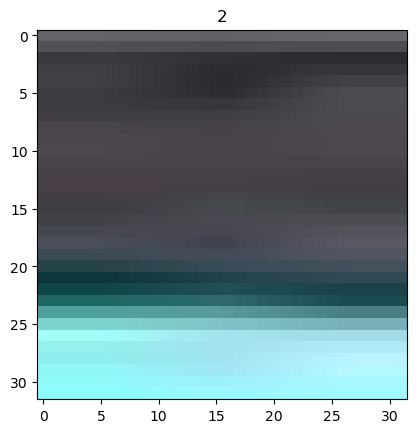

In [ ]:
# just checking to make sure the images are in the list in the correct dimensions and labels
img_check, label_check = training_im_list_green[0]
print(img_check.shape) # check dimensions should be (32, 32, 3)
plt.imshow(img_check) # looks like a square
plt.title(label_check) # makes sure the label is corresponding to what I appended above
plt.show()

In [ ]:
# combining all the data into one list
combined_training_im_list = training_im_list_green + training_im_list_yellow + training_im_list_red
# shuffling the dataset
random.shuffle(combined_training_im_list)

In [ ]:
# labeling training data images and labels
train_images = []
train_labels = []

for item in combined_training_im_list:
    train_images.append(item[0])
    train_labels.append(item[1])

# changing them to be arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

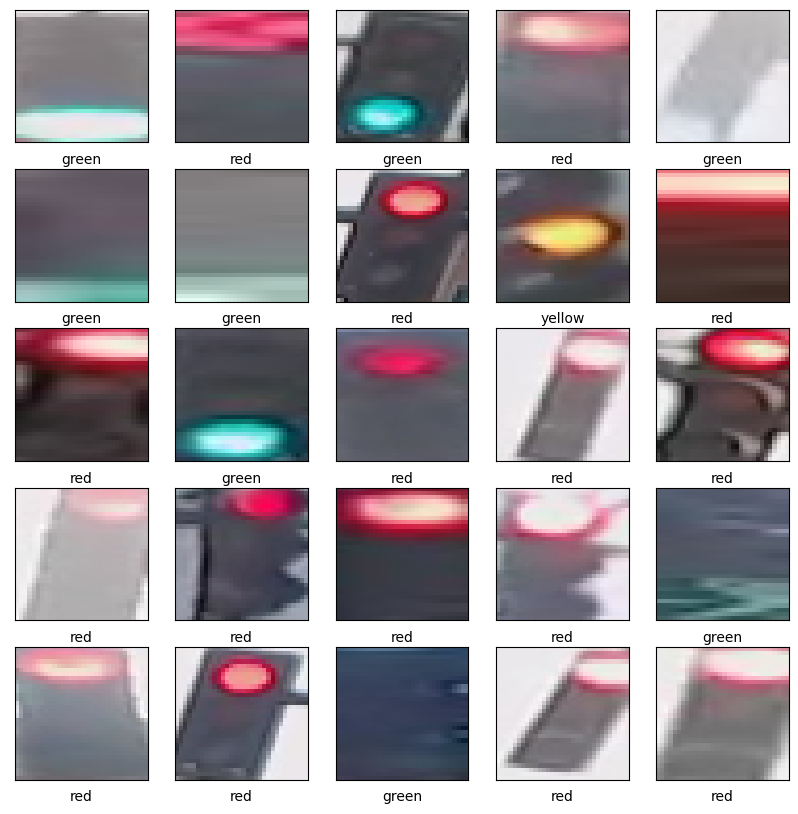

In [ ]:
# checking to see that a sample of the data is being labeled correctly by the class name
class_names = ['red', 'yellow', 'green']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()
# everything is being labeled correctly

In [ ]:
# reading in test data, putting it into one list, and preprocessing data(same process as above)
test_im_list = []

for file in glob.glob("traffic_light_images/test/green/*"):
    im = mpimg.imread(file)
    im = standardize_input(im)
    test_im_list.append((im,2))

for file in glob.glob("traffic_light_images/test/yellow/*"):
    im = mpimg.imread(file)
    im = standardize_input(im)
    test_im_list.append((im,1))

for file in glob.glob("traffic_light_images/test/red/*"):
    im = mpimg.imread(file)
    im = standardize_input(im)
    test_im_list.append((im,0))

random.shuffle(test_im_list)

test_images = []
test_labels = []
for item in test_im_list:
    test_images.append(item[0])
    test_labels.append(item[1])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

**First Algorithm: Tensorflow/Keras CNN**

In [ ]:
# splitting the data into validation data and then training data
X_train_val, X_test, y_train_val, y_test = train_test_split(train_images, train_labels, test_size=0.3, random_state=1) # in the CNN ICHW, I saw that there was validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1) # further divide training data

In [ ]:
# setting up the CNN in Keras
model = tf.keras.Sequential()

# add a 2D convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu', input_shape=(32, 32, 3)))  # Adjust input shape for RGB images

# add a max pooling layer
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))

# adding another 2D convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

# add another max pooling layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

# flattening the layers into a 1D array
model.add(tf.keras.layers.Flatten())

# add a fully connected dense layer
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1',
    activation='relu'))

# add a dropout layer to prevent overfitting
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add an output dense layer
model.add(tf.keras.layers.Dense(
    units=3, name='fc_2',
    activation='softmax'))

In [ ]:
model.summary() # shows what is above

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 16, 16, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 8, 8, 64)          0         
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              4195328   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [ ]:
# compiling the model by accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# using 20 epochs based on the ICHW, and the data from earlier
history = model.fit(X_train, y_train, epochs=20, validation_data = (X_train_val, y_train_val))

Epoch 1/20
20/20 [==============================] - 3s 136ms/step - loss: 0.3866 - accuracy: 0.8585 - val_loss: 0.1514 - val_accuracy: 0.9337
Epoch 2/20
20/20 [==============================] - 2s 117ms/step - loss: 0.0490 - accuracy: 0.9855 - val_loss: 0.0206 - val_accuracy: 0.9952
Epoch 3/20
20/20 [==============================] - 2s 117ms/step - loss: 0.0260 - accuracy: 0.9904 - val_loss: 0.0174 - val_accuracy: 0.9964
Epoch 4/20
20/20 [==============================] - 2s 116ms/step - loss: 0.0290 - accuracy: 0.9887 - val_loss: 0.0111 - val_accuracy: 0.9976
Epoch 5/20
20/20 [==============================] - 2s 122ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 0.9988
Epoch 6/20
20/20 [==============================] - 2s 127ms/step - loss: 0.0147 - accuracy: 0.9936 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 2s 122ms/step - loss: 0.0540 - accuracy: 0.9775 - val_loss: 0.0173 - val_accuracy: 0.9928
Epoch 

**First Algorithm: Evaluating Performance for Tensorflow/Keras CNN**

In [ ]:
# using the testing data to check the accuracy of the model.
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Print the test loss and accuracy
print('\nTest Loss:. {:.2f}%'.format(test_loss*100))
print('Test Accuracy:. {:.2f}%'.format(test_accuracy*100))

10/10 [==============================] - 0s 7ms/step - loss: 0.0176 - accuracy: 0.9933

Test Loss:. 1.76%
Test Accuracy:. 99.33%


**First Algorithm: Predictions (No "RED" lights must misclassfied)**

10/10 [==============================] - 0s 6ms/step


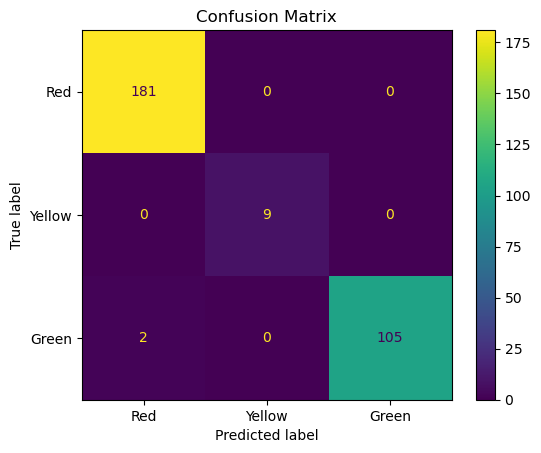

In [ ]:
# making the y_pred
predicted_labels = model.predict(test_images)

# due to an error, decided to convert the predicted_labels to np.argmax()
predicted_labels = np.argmax(predicted_labels, axis=1)

# creating confusion matrix
confmat = confusion_matrix(test_labels, predicted_labels)

# making sure to label each row so its easily readable
cmd = ConfusionMatrixDisplay(confmat, display_labels=['Red', 'Yellow', 'Green'])
cmd.plot()
plt.title('Confusion Matrix')
plt.show()

**First Algorithm: Model Accuracy and Loss Graphs**

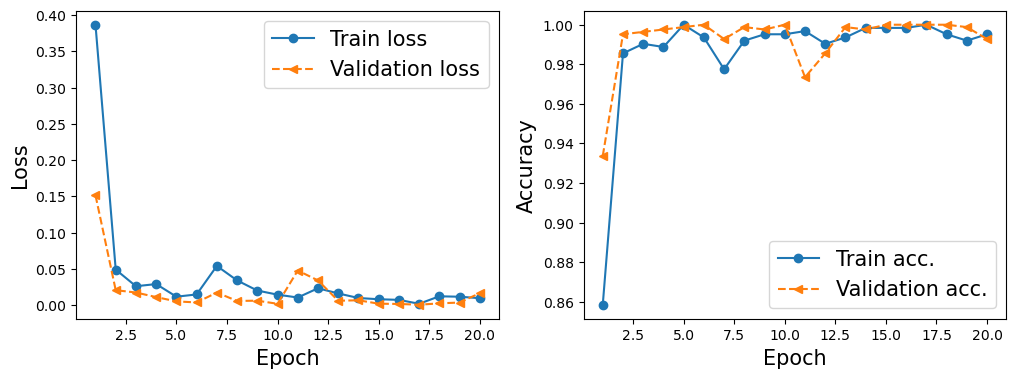

In [ ]:
# creating the accuracy and loss graph based on the ICHW for CNN
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

**First Algorithm: Summarizing Results for Tensorflow/Keras CNN**

For the first algorithm, the accuracy is very high with a 99.33% which is well above the 90% that is required. This shows that the Tensorflow/Keras CNN model is performing well with the test dataset. The confusion matrix shows how well the model does across the different colors. The true classes are the rows and the columns and the predicted classes. Based on the confusion matrix produced, the RED lights(first row) were being classified 100% correct with 0 misclassifcations across with 181 true positives, the YELLOW lights(middle row) is also being classified correctly with 9 true positives, while the GREEN light(last row) is mostly correct with 105 true positives, with only 2 misclassified as red. The Tensorflow/Keras CNN Training Accuracy and Loss graphs show that around when Epoch = 2.5, the accuracy increases to almost 100%, and the loss decreases to 0% sharply. For the Validation accuracy, the loss is low at 0-0.15 and the accuracy is high at 0.93-1 across 20 Epochs. The Tensorflow/Keras CNN model has a high accuracy and no RED lights misclassifications which shows that the model is able to distinguish red, yellow, and green lights well. In real life, this would be a very good thing as red misclassifications would cause accidents in automous driving.  

**Second Algorithm: SVM**

In [ ]:
# splitting the data and flatting the data since SVM takes 2D arrays
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.3,random_state=1)
train_images_flat = np.array([im.flatten() for im in X_train])
test_images_flat = np.array([im.flatten() for im in X_test])

In [ ]:
# picking the parameters and using sklearn svm model
svm = SVC(kernel='linear')
svm.fit(train_images_flat, y_train)

SVC(kernel='linear')

**Second Algorithm: Evaluate Performance for SVM**

In [ ]:
# showing the accuracies score from the model when looking at the testing data
y_pred = svm.predict(test_images_flat)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Test Acc. {:.2f}%'.format(accuracy*100))

Test Acc. 99.44%


**Second Algorithm: Predictions(No "RED" lights must misclassfied)**

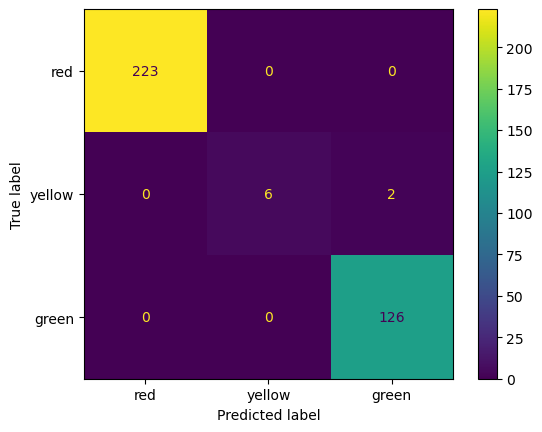

In [ ]:
# making a confusion matrix to check for misclassifications
confmat = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confmat, display_labels=['red','yellow','green'])
cmd.plot()

**Second Algorithm: Model Accuracy and Loss Graphs**

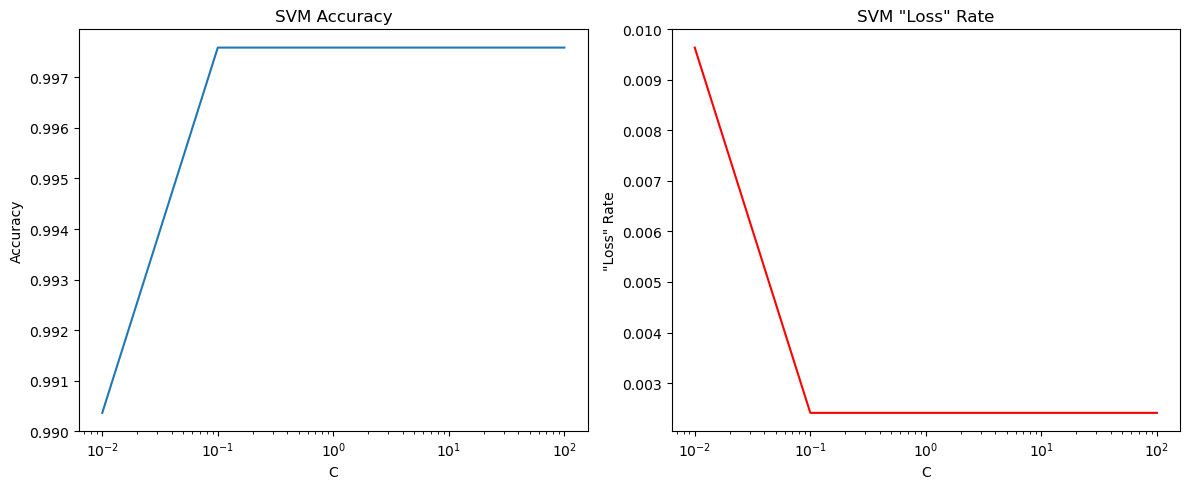

In [ ]:
# by using pipeline svc and gridsearch, we can create accuracy and loss graphs
pipe_svc = make_pipeline(SVC(kernel="linear")) # using svc and pipelining

param_range = [0.01, 0.1, 1.0, 10.0, 100.0] # selecting a range

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(train_images_flat, y_train)

results = gs.cv_results_
params = [params['svc__C'] for params in param_grid]
scores = results['mean_test_score']

# there is no way to track loss with a knn so we assume its the inverse of accurcy
loss_rate = 1 - scores

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.xscale('log')
plt.plot(param_range, scores)
plt.title('SVM Accuracy')
plt.xlabel('C')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.xscale('log')
plt.plot(param_range, loss_rate, color='red')
plt.title('SVM "Loss" Rate')
plt.xlabel('C')
plt.ylabel('"Loss" Rate')

plt.tight_layout()
plt.show()

**Second Algorithm: Summarizing Results for SVM**

For the second algorithm, the accuracy is very high with a 99.44% which is well above the 90% that is required. This shows that the SVM model is performing well with the test dataset. The confusion matrix shows how well the model does across the different colors. The true classes are the rows and the columns and the predicted classes. Based on the confusion matrix produced, the RED lights(first row) were being classified 100% correct with 0 misclassifcations across with 223 true positives, the GREEN light(last row) is correct with 126 true positives, while the YELLOW lights(middle row) is also being classified mostly correctly with 6 true positives but with 2 misclassified as green. The SVM Accuracy and Loss graphs show that around when C = 0.1, the accuracy increases to almost 100%, and the loss decreases to 0% sharply. The SVM model has a high accuracy and no RED lights misclassifications which shows that the model is able to distinguish red, yellow, and green lights well. In real life, this would be a very good thing as red misclassifications would cause accidents in automous driving.  